In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pylab as plt
import random
from scipy import stats
from sklearn.neighbors import KDTree
import time
from sklearn.metrics import mean_squared_error

In [2]:
## DATA ##

file_path = "/project/projectdirs/desi/spectro/fastspecfit/everest/catalogs/fastspec-everest-sv1-bright.fits"
data=Table.read(file_path,hdu=1)
snr=data["HALPHA_EW"]*np.sqrt(data["HALPHA_EW_IVAR"])
#data

In [3]:
## getting good data of size n
file_path = "/project/projectdirs/desi/spectro/fastspecfit/everest/catalogs/fastphot-everest-sv1-bright.fits"
data2=Table.read(file_path,hdu=1)
data3=Table.read(file_path,hdu=2)
#lines=["OII_3726_EW","HGAMMA_EW","HBETA_EW","OIII_4959_EW","OIII_5007_EW","NII_6548_EW","HALPHA_EW","NII_6584_EW","SII_6716_EW","SII_6731_EW"]
lines=["HALPHA_EW"]
#lines=["HALPHA_EW"]
N=len(data["TARGETID"])
for line in lines:
    n=50*10**3
    positions=[]
    for i in range(N):
        k=0
        # if snr[i]<1:
        #     k+=1
        if data[line][i]==0:
            k+=1
        if data2["KCORR_SDSS_U"][i]==0:
            k+=1
        if k==0:
            positions.append(i)
    print(len(positions))

    #magnitude_names=["FLUX_SYNTH_MODEL_G","FLUX_SYNTH_MODEL_R","FLUX_SYNTH_MODEL_Z","FLUX_SYNTH_MODEL_W1","FLUX_SYNTH_MODEL_W2"]
    #magnitude_names=["KCORR_SDSS_U","KCORR_SDSS_G","KCORR_SDSS_R","KCORR_SDSS_I","KCORR_SDSS_Z"]
    magnitude_names=["ABSMAG_SDSS_U","ABSMAG_SDSS_G","ABSMAG_SDSS_R","ABSMAG_SDSS_I","ABSMAG_SDSS_Z"]
    #jj=random.sample(range(0,len(positions)),n)
    jj=np.arange(n)
    EW=np.zeros(n)
    ivar=np.zeros(n)
    target_ids=np.zeros(n,int)
    magnitudes=np.zeros([n,len(magnitude_names)])

    for i in range(n):
        target_ids[i]=data["TARGETID"][positions[jj[i]]]
        EW[i]=data[line][positions[jj[i]]]
        ivar[i]=data[line+"_IVAR"][positions[jj[i]]]
        for j in range(len(magnitude_names)):
            magnitudes[i,j]=data2[magnitude_names[j]][positions[jj[i]]]
            

    # with open("/global/homes/a/ashodkh/results/target_ids.txt",'w') as f:    
    #     for i in range(n):
    #         f.write(str(target_ids[i])+"\n")
            
    ones=np.ones([n,1])
    x=np.zeros([n,len(magnitude_names)-1])
    for i in range(n):
        for j in range(len(magnitude_names)-1):
            x[i,j]=magnitudes[i,j]-magnitudes[i,j+1]
    x=np.concatenate((ones,x),axis=1)

    av_x=np.zeros(x.shape[1]-1)
    std_x=np.zeros(x.shape[1]-1)
    for i in range(1,x.shape[1]):
        av_x[i-1]=np.average(x[:,i])
        std_x[i-1]=np.std(x[:,i])
        x[:,i]=(x[:,i]-av_x[i-1])/std_x[i-1]


    N_cv=10
    x_split=np.split(x,N_cv)
    EW_split=np.split(EW,N_cv)
    ivar_split=np.split(ivar,N_cv)
    EW_fit_all=[]
    EW_obs_all=[]
    ivar_all=[]
    spearman_all=[]
    rms_all=[]
    nmad_all=[]
    nmad2_all=[]
    alpha=0.006
    for i in range(N_cv):
        x_valid=x_split[i]
        EW_valid=EW_split[i]
        ivar_valid=ivar_split[i]
        x_to_combine=[]
        EW_to_combine=[]
        for j in range(N_cv):
            if j!=i:
                x_to_combine.append(x_split[j])
                EW_to_combine.append(EW_split[j])
        x_train=np.concatenate(tuple(x_to_combine),axis=0)
        EW_train=np.concatenate(tuple(EW_to_combine),axis=0)
        nl=100
        tree=KDTree(x_train[:,:])
        dist, ind=tree.query(x_valid[:,:],k=nl)

        zeros=np.where(dist==0)[0]
        print(zeros)
        # for j in range(len(zeros)):
        dist=np.delete(dist,obj=zeros,axis=0)
        ind=np.delete(ind,obj=zeros,axis=0)
        x_valid=np.delete(x_valid,obj=zeros,axis=0)
        EW_valid=np.delete(EW_valid,obj=zeros,axis=0)
        ivar_valid=np.delete(ivar_valid,obj=zeros,axis=0)
        n_valid=x_valid.shape[0]

        theta=np.zeros([n_valid,x.shape[1],1])
        W=np.zeros([n_valid,nl,nl])
        X=np.zeros([n_valid,nl,x.shape[1]])
        Y=np.zeros([n_valid,nl,1])
        for j in range(nl):
            W[:,j,j]=1/dist[:,j]
            #W[:,j,j]=1
            #W[:,j,j]=np.exp(-dist[:,j]/alpha)
            X[:,j,:]=x_train[ind[:,j],:]
            Y[:,j,0]=EW_train[ind[:,j]]
        a1=np.zeros([n_valid,x.shape[1],1])
        a2=np.zeros([n_valid,x.shape[1],x.shape[1]])
        for ii in range(n_valid):
            a1[ii,:,:]=np.matmul(X[ii,:,:].transpose(),np.matmul(W[ii,:,:],Y[ii,:,:]))
            a2[ii,:,:]=np.matmul(X[ii,:,:].transpose(),np.matmul(W[ii,:,:],X[ii,:,:]))
            theta[ii,:,:]=np.matmul(np.linalg.inv(a2[ii,:,:]),a1[ii,:,:])
        EW_fit=np.zeros(n_valid)
        EW_used=np.zeros(n_valid)
        nmad=np.zeros(n_valid)
        nmad2=np.zeros(n_valid)
        for ii in range(n_valid):
            EW_fit[ii]=np.matmul(theta[ii,:,:].transpose(),x_valid[ii,:])
            EW_used[ii]=EW_valid[ii]
            nmad[ii]=np.abs(EW_fit[ii]-EW_used[ii])
            nmad2[ii]=np.abs(EW_fit[ii]-EW_used[ii])*np.sqrt(ivar_valid[ii])
        EW_fit_all.append(EW_fit)
        EW_obs_all.append(EW_used)
        ivar_all.append(ivar_valid)
        spearman_all.append(stats.spearmanr(EW_fit,EW_used)[0])
        rms_all.append(np.sqrt(mean_squared_error(EW_fit,EW_used)))
        nmad_all.append(1.48*np.median(nmad))
        nmad2_all.append(1.48*np.median(nmad2))

    print(spearman_all)
    print(np.average(spearman_all))
    print(rms_all)
    print(np.average(rms_all))
    print(nmad_all)
    print(np.average(nmad_all))
    print(nmad2_all)
    print(np.average(nmad2_all))

    

    #with open("/global/homes/a/ashodkh/results/logEW_fit_all_nl300_exp"+str(alpha)+".txt",'w') as f:
#     with open("/global/homes/a/ashodkh/results/EW_fit_1line_nl"+str(nl)+"_distance"+line+".txt",'w') as f:    
#         for i in range(N_cv):
#             for j in range(len(EW_fit_all[i])-1):
#                 f.write(str(np.round(EW_fit_all[i][j],decimals=5))+',')
#             f.write(str(np.round(EW_fit_all[i][-1],decimals=5)))
#             f.write('\n')
#     #with open("/global/homes/a/ashodkh/results/logEW_obs_all_nl300_exp"+str(alpha)+".txt",'w') as f:
#     with open("/global/homes/a/ashodkh/results/EW_obs_1line_nl"+str(nl)+"_distance"+line+".txt",'w') as f: 
#         for i in range(N_cv):
#             for j in range(len(EW_obs_all[i])-1):
#                 f.write(str(np.round(EW_obs_all[i][j],decimals=5))+',')
#             f.write(str(np.round(EW_obs_all[i][-1],decimals=5)))
#             f.write('\n')

#     with open("/global/homes/a/ashodkh/results/EW_1line_ivar"+line+".txt",'w') as f: 
#         for i in range(N_cv):
#             for j in range(len(ivar_all[i])-1):
#                 f.write(str(np.round(ivar_all[i][j],decimals=5))+',')
#             f.write(str(np.round(ivar_all[i][-1],decimals=5)))
#             f.write('\n')

114830
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.8188973508678938, 0.8409799104391963, 0.8436627327865093, 0.8390484743820761, 0.8314827069553081, 0.8446715932748636, 0.7947903723036147, 0.8305446344697852, 0.83966819880688, 0.8287578127983124]
0.8312503787084438
[1232.7778861207, 102.47989310510165, 66.92563950194732, 131.92113146621307, 118.70732016938321, 155.9117744819301, 235.0481107708653, 133.5589150587738, 178.42491966806142, 726.6651958466636]
308.24207861896394
[10.881502084208753, 11.796898111515898, 10.676416990228372, 10.901012010046658, 10.796067326387485, 11.55506272507106, 11.339119537777606, 10.146881032089691, 10.532105527104557, 11.489956224856531]
11.01150215692866
[8.132658461917023, 8.457192690866265, 8.811042513066775, 6.699028881584694, 13.674694361243443, 11.48935995871318, 9.57598575138528, 13.98945571967999, 12.366106544920436, 10.521737291661138]
10.371726217503824


(-50.0, 200.0)

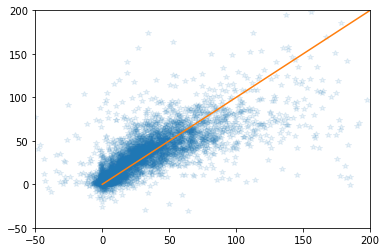

In [4]:
plt.plot(EW_obs_all[0],EW_fit_all[0],'*',alpha=0.1)
plt.plot(np.arange(0,200,0.1),np.arange(0,200,0.1))
plt.xlim((-50,200))
plt.ylim((-50,200))